In [460]:
from PIL import Image
import pygsp.graphs as graphs
import numpy as np
import matplotlib.pyplot as plt
import spectral_denoiser
import importlib
from tqdm import tqdm
import pandas as pd

importlib.reload(spectral_denoiser)

N = 32
# True_Image = np.asarray(Image.open("noodle.jpg").resize((N,N)))
# Theta = True_Image.reshape(-1,3)
G = graphs.Grid2d(N)

In [478]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

cifar = unpickle('cifar-10-batches-py/data_batch_1')
images = cifar[b'data'][:1000]

def transform(im):
    img = np.zeros((N,N,3))
    img[:,:,0] = im[:1024].reshape(N,N)
    img[:,:,1] = im[1024:2048].reshape(N,N)
    img[:,:,2] = im[2048:].reshape(N,N)
    return img.astype(np.uint8)

images = [transform(x) for x in images]

In [522]:
np.random.seed(0)
sd = spectral_denoiser.Spectral_Denoiser(G)

def run_experiment(Theta, Noisy_Image, tau):
    best_restores = []
    best_MSEs = []

    Restored_avgs = []
    MSE_avgs = []
    Restored_NN = []
    MSE_NN = []

    Restored_sd = sd.remove_gaussian_noise(Noisy_Image.reshape(-1,3),tau=tau)
    MSE_sd = np.linalg.norm(Restored_sd - Theta)

    for t in [1,2,5,10]:
        restored_avgs = sd.local_average(Noisy_Image, t=t)
        Restored_avgs.append(restored_avgs)
        MSE_avgs.append(np.linalg.norm(restored_avgs - Theta))

    Best_MSE_avgs = np.min(MSE_avgs)
    Best_avgs_Restoration = Restored_avgs[np.argmin(best_MSE_avgs)]

    for tau2 in [1,25,50,100]:
        restored_nn = sd.nuclear_norm_appx(Noisy_Image.reshape(N,N,3), tau=tau2)
        Restored_NN.append(restored_nn)
        MSE_NN.append(np.linalg.norm(restored_nn - Theta.reshape(N,N,3)))

    Best_MSE_NN = np.min(MSE_NN)
    Best_NN_Restoration = Restored_NN[np.argmin(best_MSE_NN)]

    best_MSEs.append([MSE_sd, Best_MSE_avgs, Best_MSE_NN])
    best_restores.append([Restored_sd, Best_avgs_Restoration, Best_NN_Restoration])
    
    MSEs = ([MSE_sd] + MSE_avgs + MSE_NN)/np.linalg.norm(Theta)
    return (best_restores, MSEs)

In [527]:
MSEs = {}
for sigma in [5,25,50,100,150]:
    
    theta = np.hstack([x.reshape(-1,3) for x in images])
    T = theta.shape[0]*theta.shape[1]
    
    noisy = (np.random.randn(T).reshape(theta.shape)*sigma + theta)
    tau = sd.estimate_tau_for_gaussian(noisy)

    print(tau)
    theta = [theta[:,3*i:3*i + 3] for i in range(int(theta.shape[1]/3))]
    noisy = [noisy[:,3*i:3*i + 3] for i in range(int(noisy.shape[1]/3))]
    MSEs_all = np.mean([run_experiment(Theta=a, Noisy_Image=b, tau=tau)[1] for a,b in zip(theta,noisy)],axis=0)
    MSEs[sigma] = [np.round(100*x,1) for x in MSEs_all]
    

1
[[0.02049716]]
[[0.58348262]]
[[2.87743773]]
[[6.79493163]]


In [560]:
sigma = 50
index = 7
theta = images[index].reshape(-1,3)
T = theta.shape[0]*theta.shape[1]
noisy = (np.random.randn(T).reshape(theta.shape)*sigma + theta)
tau = 0.58841474

best_restores = run_experiment(Theta=theta, Noisy_Image=noisy, tau=tau)[0][0]

/var/folders/c7/y21v7xk53q1_mp_xdh4drmdw0000gn/T/ipykernel_14217/1618520374.py:6: RuntimeWarning: invalid value encountered in cast
  ax[2].imshow((best_restores[0]).reshape(N,N,3).astype(np.uint32))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/var/folders/c7/y21v7xk53q1_mp_xdh4drmdw0000gn/T/ipykernel_14217/1618520374.py:8: RuntimeWarning: invalid value encountered in cast
  ax[3].imshow((best_restores[1]).reshape(N,N,3).astype(np.uint32))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/var/folders/c7/y21v7xk53q1_mp_xdh4drmdw0000gn/T/ipykernel_14217/1618520374.py:10: RuntimeWarning: invalid value encountered in cast
  ax[4].imshow((best_restores[2]).reshape(N,N,3).astype(np.uint32))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


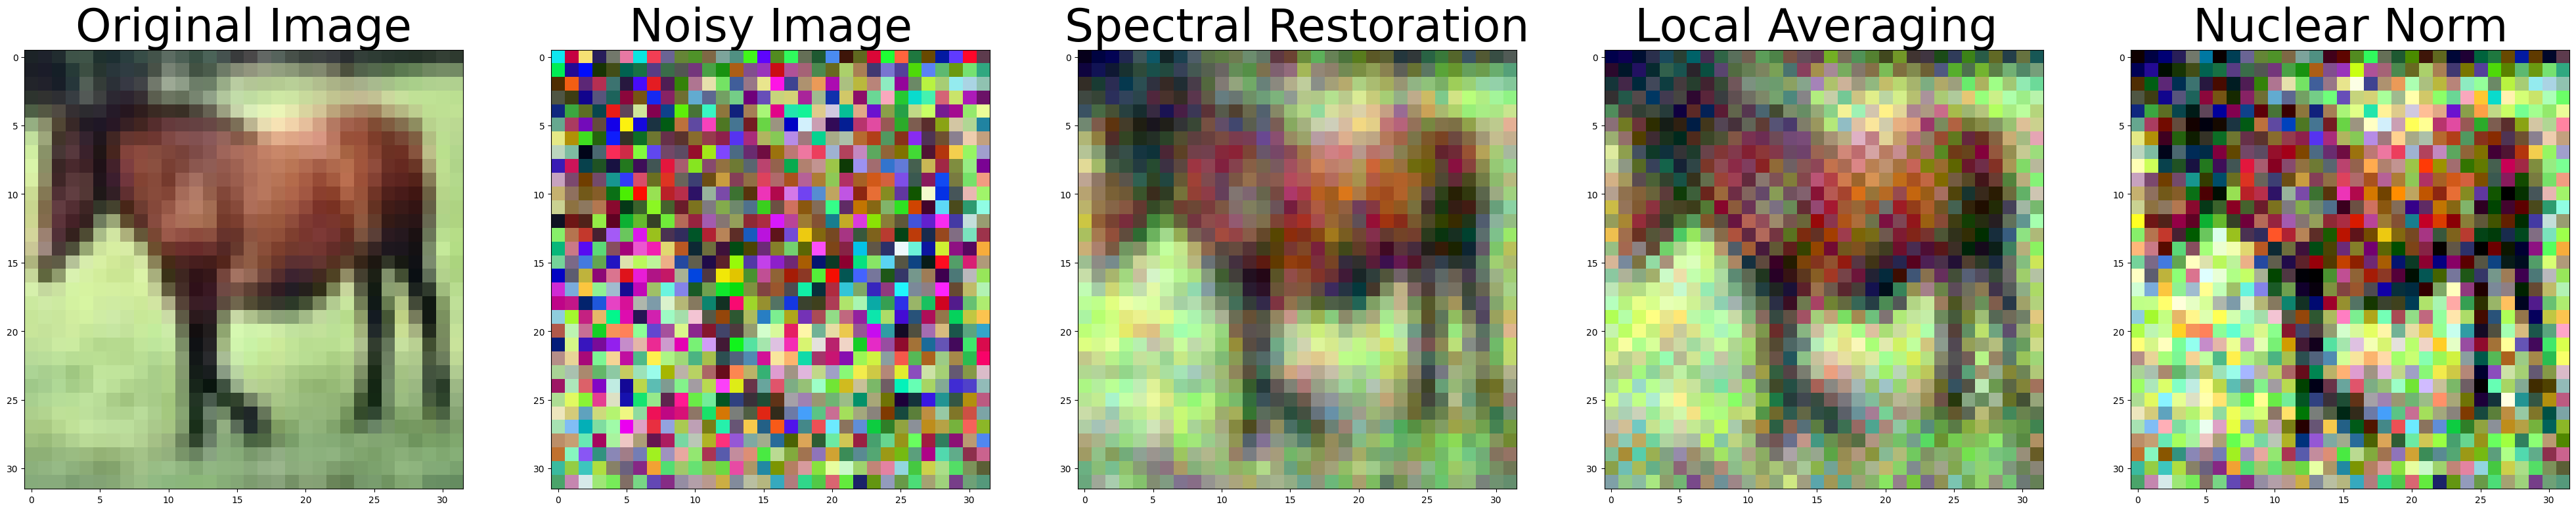

In [565]:
fig, ax = plt.subplots(1,5, figsize=(50,15))
ax[0].imshow(theta.reshape(N,N,3).astype(np.uint8))
ax[0].set_title("Original Image",fontsize=50)
ax[1].imshow(noisy.reshape(N,N,3).astype(np.uint8))
ax[1].set_title("Noisy Image",fontsize=50)
ax[2].imshow((best_restores[0]).reshape(N,N,3).astype(np.uint32))
ax[2].set_title("Spectral Restoration",fontsize=50)
ax[3].imshow((best_restores[1]).reshape(N,N,3).astype(np.uint32))
ax[3].set_title("Local Averaging ",fontsize=50)
ax[4].imshow((best_restores[2]).reshape(N,N,3).astype(np.uint32))
ax[4].set_title("Nuclear Norm",fontsize=50)

plt.savefig("Image_Comparison_Visualization.png")

In [532]:
df = pd.DataFrame()
df['5'] = MSEs[5]
df['25'] = MSEs[25]
df['50'] = MSEs[50]
df['100'] = MSEs[100]
df['150'] = MSEs[150]

df.index = ['Spectral', 'Local Avg. (t=1)', 'Local Avg. (t=2)', 'Local Avg. (t=5)', 
            'Local Avg. (t=10)', 'Nuclear Norm (tau = 1)', 'Nuclear Norm (tau = 25)', 
           'Nuclear Norm (tau = 50)', 'Nuclear Norm (tau = 100)']

df

,5,25,50,100,150
Spectral,11.5,18.5,18.4,22.6,26.0
Local Avg. (t=1),9.6,14.0,22.5,41.8,61.7
Local Avg. (t=2),11.9,14.2,19.6,33.2,47.9
Local Avg. (t=5),16.5,17.3,19.6,26.8,35.6
Local Avg. (t=10),19.9,20.3,21.5,25.5,30.9
Nuclear Norm (tau = 1),3.9,19.8,39.7,79.5,119.2
Nuclear Norm (tau = 25),4.0,17.8,37.3,76.9,116.5
Nuclear Norm (tau = 50),5.5,16.1,34.9,74.3,113.8
Nuclear Norm (tau = 100),8.9,14.1,30.7,69.1,108.4


In [533]:
print(df.to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &     5 &    25 &    50 &   100 &    150 \\
\midrule
Spectral                 &  11.5 &  18.5 &  18.4 &  22.6 &   26.0 \\
Local Avg. (t=1)         &   9.6 &  14.0 &  22.5 &  41.8 &   61.7 \\
Local Avg. (t=2)         &  11.9 &  14.2 &  19.6 &  33.2 &   47.9 \\
Local Avg. (t=5)         &  16.5 &  17.3 &  19.6 &  26.8 &   35.6 \\
Local Avg. (t=10)        &  19.9 &  20.3 &  21.5 &  25.5 &   30.9 \\
Nuclear Norm (tau = 1)   &   3.9 &  19.8 &  39.7 &  79.5 &  119.2 \\
Nuclear Norm (tau = 25)  &   4.0 &  17.8 &  37.3 &  76.9 &  116.5 \\
Nuclear Norm (tau = 50)  &   5.5 &  16.1 &  34.9 &  74.3 &  113.8 \\
Nuclear Norm (tau = 100) &   8.9 &  14.1 &  30.7 &  69.1 &  108.4 \\
\bottomrule
\end{tabular}

